In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

from sympy import symbols, cos, sin, pi, simplify, diff, lambdify, det, solve
from sympy.matrices import Matrix
from sympy.plotting import plot
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

### Forward Kinematics

**We already extracted Forward Kinematics equations**

$$\begin{align}\left[
\begin{matrix}
{px} \\
{py} \\
{pz}
\end{matrix}\right] =  
\left[ 
\begin{array}\\
(a2+d3).cos({\theta}_1).cos({\theta}_2) \\
(a2+d3).sin({\theta}_1).cos({\theta}_2) \\
d1 + (a2 + d3). sin({\theta}_2)
\end{array}
\right],
\end{align}$$




In [2]:
#constants
d1, a2 = symbols('d1,a2')

#variables
theta1, theta2, d3 = symbols('theta1,theta2, d3')

In [3]:
T1 = Rz(theta1)*Tz(d1)
R1 = T1[:3, :3]
O1 = T1[:3, -1]

In [4]:
T2 = Ry(theta2)*Tx(a2)
R2 = T2[:3, :3]
O2 = T2[:3, -1]

In [5]:
T3 = Tx(d3)
R3 = T3[:3, :3]
O3 = T3[:3, -1]

In [6]:
H = T1 * T2 * T3
R = H[:3, :3]
O = H[:3, -1]

### Classical Approach (partial derivatives)

In [7]:
a11 = diff(H[0,3], theta1) # differentiate px with theta_1
a12 = diff(H[0,3], theta2) # differentiate px with theta_2
a13 = diff(H[0,3], d3)     # differentiate px with d3

a21 = diff(H[1,3], theta1) # differentiate py with theta_1
a22 = diff(H[1,3], theta2) # differentiate py with theta_2
a23 = diff(H[1,3], d3)     # differentiate py with d3

a31 = diff(H[2,3], theta1) # differentiate pz with theta_1
a32 = diff(H[2,3], theta2) # differentiate pz with theta_2
a33 = diff(H[2,3], d3)     # differentiate pz with d3


# get infinitesimal rotations of theta1
R_ = simplify(Rzd(theta1)*Rz(theta1).inv())
a4 = Matrix([R_[2,1], R_[0,2], R_[1,0]])

# get infinitesimal rotations of theta2
R_ = simplify(Rz(theta1)*Ryd(theta2)*(Rz(theta1)*Ry(theta2)).inv())
a5 = Matrix([R_[2,1], R_[0,2], R_[1,0]])

# get infinitesimal rotations of d3
R_ = simplify(Rz(theta1)*Ry(theta2)*Txd(d3)*(Rz(theta1)*Ry(theta2)*Tx(d3)).inv())
a6 = Matrix([R_[2,1], R_[0,2], R_[1,0]])

From above the above differentiation, the Jacobian elements can be used to construct the Matrix,

In [8]:
J_analytically = Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33], [a4, a5, a6]]) # assemble into matix form
J_analytically = simplify(J_analytically)
J_analytically

Matrix([
[-1.0*(a2 + d3)*sin(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta2)*cos(theta1), 1.0*cos(theta1)*cos(theta2)],
[ 1.0*(a2 + d3)*cos(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta1)*sin(theta2), 1.0*sin(theta1)*cos(theta2)],
[                                     0,             -1.0*(a2 + d3)*cos(theta2),            -1.0*sin(theta2)],
[                                     0,                       -1.0*sin(theta1),                           0],
[                                     0,                        1.0*cos(theta1),                           0],
[                                     1,                                      0,                           0]])

### Geometric Approach (cross products)

In [9]:
O0 = Matrix([0,0,0])
z1 = Matrix([0,0,1])
z1

Matrix([
[0],
[0],
[1]])

In [10]:
z2 = T1
z2 = z2[:3,1]
z3 = T1*T2
z3 = z3[:3,0] #first column because rotation is around X axis
z2

Matrix([
[-1.0*sin(theta1)],
[ 1.0*cos(theta1)],
[               0]])

In [11]:
z3

Matrix([
[1.0*cos(theta1)*cos(theta2)],
[1.0*sin(theta1)*cos(theta2)],
[           -1.0*sin(theta2)]])

In [12]:
# The first joint (revolute)
Jv1 = z1.cross(O - O0);
Jw1 = z1;

In [13]:
# The second joint (revolute)
Jv2 = z2.cross(O - O1);
Jw2 = z2;
Jv2

Matrix([
[                                                                                                            1.0*(-1.0*a2*sin(theta2) - 1.0*d3*sin(theta2))*cos(theta1)],
[                                                                                                            1.0*(-1.0*a2*sin(theta2) - 1.0*d3*sin(theta2))*sin(theta1)],
[-1.0*(1.0*a2*sin(theta1)*cos(theta2) + 1.0*d3*sin(theta1)*cos(theta2))*sin(theta1) - 1.0*(1.0*a2*cos(theta1)*cos(theta2) + 1.0*d3*cos(theta1)*cos(theta2))*cos(theta1)]])

In [14]:
# The third joint (prismatic)
Jv3 = z3;
Jw3 = Matrix([0,0,0]);

In [15]:
Jg = simplify(Matrix([[Jv1, Jv2, Jv3],
                      [Jw1, Jw2, Jw3]]))

Jg

Matrix([
[-1.0*(a2 + d3)*sin(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta2)*cos(theta1), 1.0*cos(theta1)*cos(theta2)],
[ 1.0*(a2 + d3)*cos(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta1)*sin(theta2), 1.0*sin(theta1)*cos(theta2)],
[                                     0,             -1.0*(a2 + d3)*cos(theta2),            -1.0*sin(theta2)],
[                                     0,                       -1.0*sin(theta1),                           0],
[                                     0,                        1.0*cos(theta1),                           0],
[                                     1,                                      0,                           0]])

### Numerical Derivatives Approach

In [16]:
J1p=Rzd(theta1)*Tz(d1)*Ry(theta2)*Tx(a2)*Tx(d3)
J1p=simplify(J1p)
J1p

Matrix([
[-1.0*sin(theta1)*cos(theta2), -1.0*cos(theta1), -1.0*sin(theta1)*sin(theta2), -1.0*(a2 + d3)*sin(theta1)*cos(theta2)],
[ 1.0*cos(theta1)*cos(theta2), -1.0*sin(theta1),  1.0*sin(theta2)*cos(theta1),  1.0*(a2 + d3)*cos(theta1)*cos(theta2)],
[                           0,                0,                            0,                                      0],
[                           0,                0,                            0,                                      0]])

In [17]:
rotation_to_transformation_matrix(R.T)

Matrix([
[1.0*cos(theta1)*cos(theta2), 1.0*sin(theta1)*cos(theta2), -1.0*sin(theta2), 0.0],
[           -1.0*sin(theta1),             1.0*cos(theta1),                0, 0.0],
[1.0*sin(theta2)*cos(theta1), 1.0*sin(theta1)*sin(theta2),  1.0*cos(theta2), 0.0],
[                        0.0,                         0.0,              0.0, 1.0]])

In [18]:
# diff by theta1
Td1 = Rzd(theta1)*Tz(d1)*Ry(theta2)*Tx(a2)*Tx(d3) * rotation_to_transformation_matrix(R.T)
# extract 6 components from 4x4 Td matrix to Jacobian 1st column
J1 = Matrix([Td1[0,3], Td1[1,3], Td1[2,3], Td1[2,1], Td1[0,2], Td1[1,0]])
# diff by theta2
Td2 = Rz(theta1)*Tz(d1)*Ryd(theta2)*Tx(a2)*Tx(d3) * rotation_to_transformation_matrix(R.T)
# extract 6 components from 4x4 Td matrix to Jacobian 2nd column
J2 = Matrix([Td2[0,3], Td2[1,3], Td2[2,3], Td2[2,1], Td2[0,2], Td2[1,0]])
# diff by d3
Td3 = Rz(theta1)*Tz(d1)*Ry(theta2)*Tx(a2)*Txd(d3) * rotation_to_transformation_matrix(R.T)
# extract 6 components from 4x4 Td matrix to Jacobian 3rd column
J3 = Matrix([Td3[0,3], Td3[1,3], Td3[2,3], Td3[2,1], Td3[0,2], Td3[1,0]])

# Full Jacobian 6x3
Jn = Matrix([[J1, J2, J3]])

In [19]:
simplify(Jn)

Matrix([
[-1.0*(a2 + d3)*sin(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta2)*cos(theta1), 1.0*cos(theta1)*cos(theta2)],
[ 1.0*(a2 + d3)*cos(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta1)*sin(theta2), 1.0*sin(theta1)*cos(theta2)],
[                                     0,             -1.0*(a2 + d3)*cos(theta2),            -1.0*sin(theta2)],
[                                     0,                       -1.0*sin(theta1),                           0],
[                                     0,                        1.0*cos(theta1),                           0],
[                                   1.0,                                      0,                           0]])

In [20]:
simplify(Jg)

Matrix([
[-1.0*(a2 + d3)*sin(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta2)*cos(theta1), 1.0*cos(theta1)*cos(theta2)],
[ 1.0*(a2 + d3)*cos(theta1)*cos(theta2), -1.0*(a2 + d3)*sin(theta1)*sin(theta2), 1.0*sin(theta1)*cos(theta2)],
[                                     0,             -1.0*(a2 + d3)*cos(theta2),            -1.0*sin(theta2)],
[                                     0,                       -1.0*sin(theta1),                           0],
[                                     0,                        1.0*cos(theta1),                           0],
[                                     1,                                      0,                           0]])

### Let's Compare results of all approaches

In [21]:
simplify(Jg) - simplify(Jn)

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [22]:
simplify(J_analytically) - simplify(Jn)

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [23]:
simplify(Jg) - simplify(J_analytically)

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

## Manipulator Singularities

**We need to analyze the Jacobian for singularities and to characterize each singular configuration if any**

Singularities are those manipulator configurations where it loses one or more degrees-of-freedom, i.e., it can not move further in specific direction(s). Physically, it means a manipulator would be in a singular configuration if its tip/end-effector cannot move in one or more directions. In other words, infinite joint velocities are required to move the end-effector in that particular direction(s).

Mathematically, singularities relate to the manipulator configuration(s) for which its Jacobian matrix becomes singular, i.e.,

$$det J = 0$$

In Sympy, this can be analytically calculated as,

In [24]:
Jdet = det(Jn[:3,:]) # determinant of Jacobian matrix 
detJ = simplify(Jdet)
detJ

-1.0*(a2 + d3)**2*cos(theta2)

The above result gives information about all possible singular configurations of the 2-Link Manipulator. We solve the above equation against zero and get,

This means the manipulator will be in singular configuration when the angle $\theta_2$  is either $\pm \frac{\pi}{2}$  or when $d3 = -a2$ 

                                              ======================

$$\theta_2 = \pm \frac{\pi}{2}$$ 


In this case, either px and py will be equal to zero. And this means we lost one DoF because the end-effector intersects with the base frame’s Z-axis. Thus any rotation around the base frame won’t affect the position of the end-effector.

                                              ======================
$$d3 = -a2$$

In this case and depending on the equation:
$d3 = \sqrt(r^2+s^2) - a2$

So d3 will be equal to (-a2) in case of both r and s are equal to zero.
	
And since we know:
$r = px^2+py^2$

Thus $r$ will be equal to $0$ if and only if $px$ and $py$ are both equal to $0$ which is the same as the first case.

                                              ======================

## Velocity Computation

**Now let's compute the velocity of the tool frame when joint variables are changing
with time as follows:**


**θ1(t) = sin(t); θ2(t) = cos(2t); d3(t) = sin(3t)**

In [25]:
t, theta1_t, theta2_t, d3_t = symbols('t, theta1_t, theta2_t, d3_t', real=True)
theta1_t = sin(t)
theta2_t = cos(2*t)
d3_t = sin(3*t)

In [26]:
J_time = simplify(Jn.subs([(d1,1), (a2,1), (theta1, theta1_t), (theta2, theta2_t), (d3, d3_t)]))

In [27]:
q = Matrix([theta1_t, theta2_t, d3_t])
qdot = diff(q)

In [28]:
qdot

Matrix([
[     cos(t)],
[-2*sin(2*t)],
[ 3*cos(3*t)]])

In [29]:
xi = simplify(J_time * qdot)

In [30]:
time = np.arange(0.0,10.0, 0.01)
xi_time = xi.subs(t, time)

In [31]:
xi_lam = lambdify(t, xi, modules=['numpy'])
y_vals = xi_lam(time)
y_vals

array([[[ 1.62090692e+00,  1.64969474e+00,  1.67950123e+00, ...,
          1.51834169e-01,  2.23021364e-01,  2.94514862e-01]],

       [[ 5.40302306e-01,  5.73179491e-01,  6.07006510e-01, ...,
         -8.85074791e-02, -1.33806514e-01, -1.81747086e-01]],

       [[-2.52441295e+00, -2.50068717e+00, -2.47271444e+00, ...,
         -8.33608611e-02, -1.14864633e-01, -1.41660120e-01]],

       [[ 0.00000000e+00,  3.99960002e-04,  1.59936012e-03, ...,
         -8.79155093e-01, -9.01373093e-01, -9.23344873e-01]],

       [[-0.00000000e+00, -3.99953336e-02, -7.99626753e-02, ...,
         -1.54044532e+00, -1.54856242e+00, -1.55584390e+00]],

       [[ 1.00000000e+00,  9.99950000e-01,  9.99800007e-01, ...,
         -8.55012161e-01, -8.49783417e-01, -8.44469696e-01]]])

### The following two plots are representing the tool frame velocities where:


**1-The first figure shows the linear velocities of the tool frame**


**2-And the second figure represents the angular velocities**

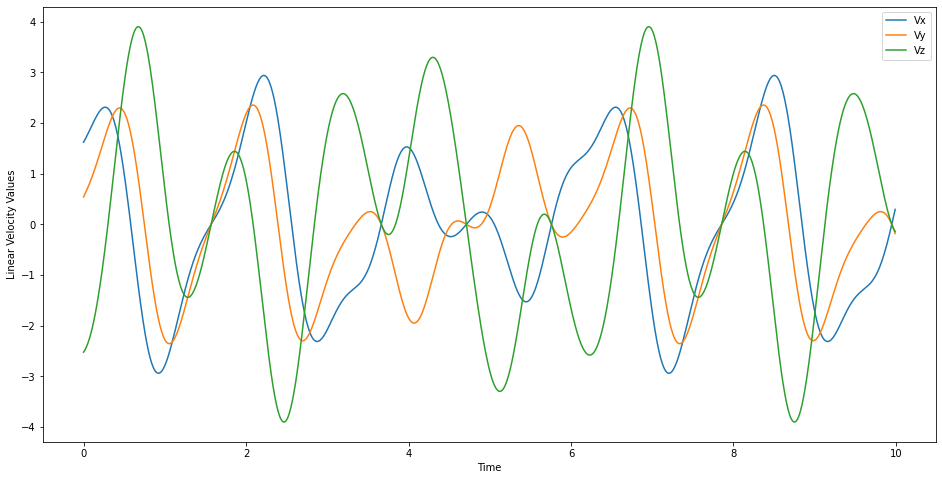

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(time, y_vals[0, 0, :], label="Vx")
sns.lineplot(time, y_vals[1, 0, :], label="Vy")
sns.lineplot(time, y_vals[2, 0, :], label="Vz")

ax.set_xlabel('Time')
ax.set_ylabel('Linear Velocity Values')
ax.legend()
plt.show()

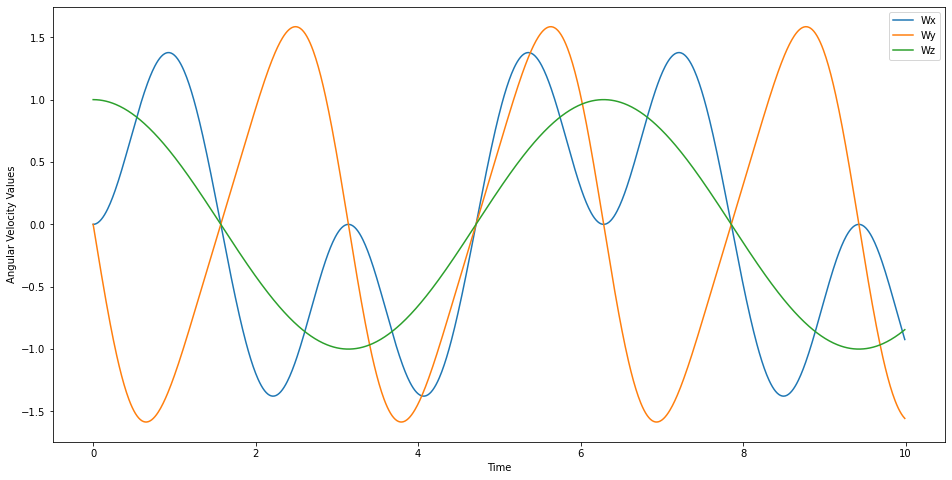

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(time, y_vals[3, 0, :], label="Wx")
sns.lineplot(time, y_vals[4, 0, :], label="Wy")
sns.lineplot(time, y_vals[5, 0, :], label="Wz")

ax.set_xlabel('Time')
ax.set_ylabel('Angular Velocity Values')
ax.legend()
plt.show()